# Weather Recognition From Images Using CNN and Explanation Predections Using LIME 
***
This notebook covers  training CNN from scratch to classify Weather images using Mutli-class Weather Dataset.
We are using Google Colab for Training Neural Network to get access to GPU for speeding up the training process.

**Dataset** : [Multiclass weather dataset](https://data.mendeley.com/datasets/4drtyfjtfy/1)

### Dataset
The dataset contains following four classes
* Cloudy
* Rainy 
* Sunrise
* Sunshine(Sunny)

We will be designing our own CNN architecture using Keras for Image Classification 

#### Loading Packages


In [0]:
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import random

####  Mounting Google Drive on Colab 
I suggest to keep data on Google drive and use it as virtual storage. Since, the virtual storage provided in Google Colab is temporary and data is lost after session is terminated and the time required for uploading data is high

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)





Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


 #### Transferring dataset zip file  from google  drive to Google colab virtual disk annd extracting dataset

In [4]:

file_name='/content/gdrive/My Drive/weather_data.zip' ## repalce the path with relevent path on your drive
os.mkdir('Data')
from zipfile import ZipFile
with ZipFile(file_name, 'r') as zip_ref:
  zip_ref.extractall('Data')


print('Extract completed!')
!ls

Extract completed!
Data  gdrive  sample_data


In [0]:
### collecting image names 
cloudy=os.listdir('Data/cloudy')
rain=os.listdir('Data/rain')
sunrise=os.listdir('Data/sunrise')
sunshine=os.listdir('Data/sunshine')

#### Exploring Dataset

**1) Cloudy Images**

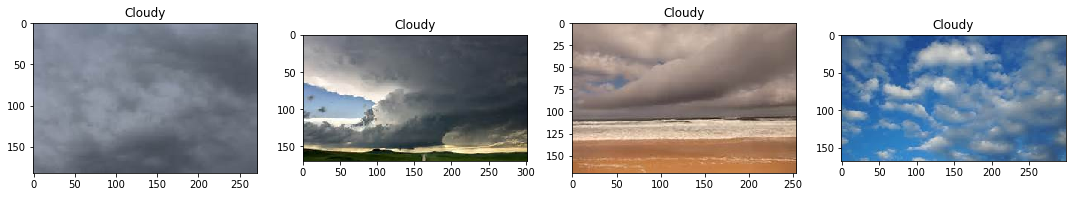

In [6]:

plt.figure(figsize = (15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    x=random.randint(0,len(cloudy))

    img = cv2.imread('Data/cloudy' + "/" + cloudy[x])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Cloudy')
    plt.tight_layout()
plt.show()

**2) Rain Images**

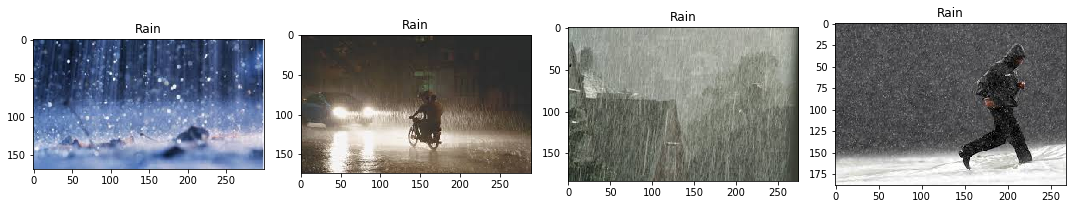

In [8]:
plt.figure(figsize = (15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    x=random.randint(0,len(rain))

    img = cv2.imread('Data/rain' + "/" + rain[x])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Rain')
    plt.tight_layout()
plt.show()

**3) Sunrise Images** 

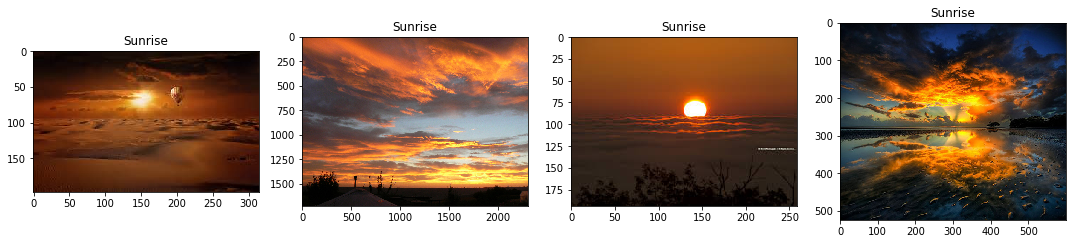

In [9]:
plt.figure(figsize = (15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    x=random.randint(0,len(cloudy))

    img = cv2.imread('Data/sunrise' + "/" + sunrise[x])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Sunrise')
    plt.tight_layout()
plt.show()

**4) Sunny Images**

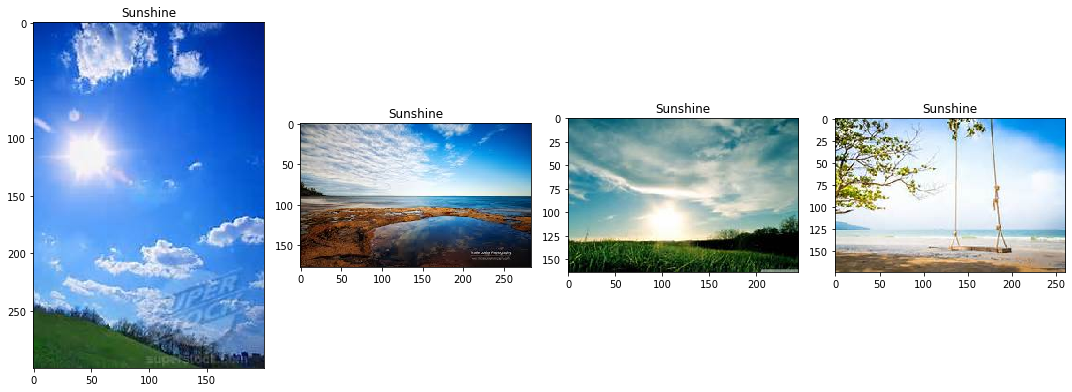

In [12]:
plt.figure(figsize = (15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    x=random.randint(0,len(sunshine))

    img = cv2.imread('Data/sunshine' + "/" + sunshine[x])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Sunshine')
    plt.tight_layout()

#### Using split-folder package to divide data set into 3 parts- Train, Validation,Test

In [13]:
!pip install split-folders

import split_folders
orig_path = '/content/Data/'
output_path = '/content/dataset/'
### split for train :validation:tet == 75:20:05
split_folders.ratio(orig_path, output=output_path, seed=254, ratio=(.75, .20,.05))

Copying files: 1125 files [00:00, 5504.20 files/s]


#### Checking number of Images in train, val and test set

In [14]:


total_train = 0
for root, dirs, files in os.walk('/content/dataset/train'):
    total_train += len(files)
print('Train set size: ',total_train)
total_val = 0
for root, dirs, files in os.walk('/content/dataset/val'):
    total_val += len(files)
print('Validation set size: ',total_val)
total_test = 0
for root, dirs, files in os.walk('/content/dataset/test'):
    total_test += len(files)
print('Test set size: ',total_test)


Train set size:  842
Validation set size:  224
Test set size:  59


#### Loading all necessary packages for  creating Covolution neural network architecture


In [15]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation,GlobalAveragePooling2D
from keras import callbacks
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K 
from keras.initializers import glorot_uniform
from keras.regularizers import l2
import scipy.misc
import matplotlib.pyplot  as plt

Using TensorFlow backend.


In [0]:
## setting train and validatin path
train_data_path = '/content/dataset/train'
validation_data_path = '/content/dataset/val'

In [0]:

#### Defining all parameters for CNN 

In [0]:
## Setting Image height and width to 150 each since all images are of varying size 
img_width=150
img_height =150
### CNN architecture parameters
batch_size = 32
samples_per_epoch = 1000
validation_steps = 32
no_filters1 = 32
no_filters2 = 64
no_filters3=128
conv1_size = 3
conv2_size = 3
conv3_size=5
pool_size = 2
## no of classes according to dataset 4 in our case
classes_num = 4
## Defining initial learning rate
lr = 0.001
epochs=200

#### Image Data Generator Generate batches of tensor image data with real-time data augmentation.
Image data genrator simplifies the process of sending data to CNN while training it directly extracts data from source path and transforms into form acceptable to CNN

In [18]:

train_datagen = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest",rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 842 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


#### Defining CNN architecture 
After multiple trial and errors I found this simple network architecture that gives good performance on training as well as validation with accuracy> 95% 

In [0]:
model = Sequential()
model.add(Conv2D(filters=no_filters1,kernel_size=(3,3), border_mode ="same",data_format='channels_last', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(Conv2D(filters=no_filters1,kernel_size=(3,3), border_mode ="same",data_format='channels_last', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),data_format='channels_last'))

model.add(Conv2D(filters=no_filters2,kernel_size=(3,3), border_mode ="same",data_format='channels_last'))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(Conv2D(filters=no_filters2,kernel_size=(3,3), border_mode ="same",data_format='channels_last'))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),data_format='channels_last'))


model.add(Conv2D(filters=no_filters3,kernel_size=(5,5), border_mode ="same",data_format='channels_last'))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),data_format='channels_last'))

model.add(GlobalAveragePooling2D())

model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
epochs = 200

### Using adam optimizer 
adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-5)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
            metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), data_format="channels_last", input_shape=(150, 150,..., padding="same")`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), data_format="channels_last", input_shape=(150, 150,..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), data_format="channels_last", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), data_format="channels_last", padding="same")`
  del sys.path[0]


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, kernel_size=(5, 5), data_format="channels_last", padding="same")`




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)     

In [0]:

## Defining Target directory for saving Models and weights
target_dir = './models'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)


#### Callbacks
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training
We are using 3 callbacks

1) Tensorboard- Gives stats of training process 

2) Modelcheckpoint - Saves the weights for the model for the epoch with best validation accuracy

3)  Reduce Lr on Pateau- Reduces Learning rate when the  validation accuracy is not increasing or its decreased for 5 continous epoch

In [0]:
log_dir = './tf-log/'
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
file_path= "models/best_weight{epoch:03d}.h5"
chkpt=callbacks.ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
lr_red=callbacks.ReduceLROnPlateau(monitor = "val_acc", factor = 0.1, patience = 5,
  verbose = 1, mode = "auto", cooldown = 0,
  min_lr = 1e-30)

cbks = [tb_cb,chkpt,lr_red]

#### Training the model using fit generator 

In [0]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=130,
    epochs=200,
    validation_data=validation_generator,
    callbacks=cbks,
    validation_steps=32)

Epoch 1/200
130/130 [==============================] - 54s 418ms/step - loss: 0.5525 - acc: 0.8041 - val_loss: 1.3643 - val_acc: 0.6982
Epoch 2/200
130/130 [==============================] - 53s 410ms/step - loss: 0.4128 - acc: 0.8711 - val_loss: 1.0657 - val_acc: 0.6104
Epoch 3/200
130/130 [==============================] - 52s 401ms/step - loss: 0.3334 - acc: 0.8935 - val_loss: 0.3098 - val_acc: 0.8828
Epoch 4/200
130/130 [==============================] - 52s 398ms/step - loss: 0.3141 - acc: 0.8981 - val_loss: 0.5050 - val_acc: 0.8018
Epoch 5/200
130/130 [==============================] - 51s 393ms/step - loss: 0.2651 - acc: 0.9160 - val_loss: 0.2656 - val_acc: 0.9053
Epoch 6/200
130/130 [==============================] - 49s 381ms/step - loss: 0.2559 - acc: 0.9131 - val_loss: 0.3274 - val_acc: 0.8887
Epoch 7/200
130/130 [==============================] - 53s 410ms/step - loss: 0.2524 - acc: 0.9199 - val_loss: 0.7179 - val_acc: 0.8193
Epoch 8/200
130/130 [===========================

KeyboardInterrupt: ignored

#### Saving the model
note : Model will be saved automatically when training is finished; but since validation accuracy was stagnant for a long time,  I Interrupted the training. You can also use early stopping callback to do this process of stopping training near minima automatically 

In [0]:
model.save('models/weather_model.h5')


## Inference

Testing the performance of Network on Test Data and checking how it is classifying images


In [0]:
from keras.models import load_model
from keras.preprocessing import image

#### Loading model and weights


In [0]:
model_final=load_model('models/weather_model.h5')
model_final.load_weights('/content/gdrive/My Drive/best_weight037.h5')

In [0]:
model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)       

#### Testing the model class wise on test data
Classes : 


Cloudy   : 0 

Rain     : 1

Sunrise : 2

Sunshine : 3 


#### Testing model on sunshine data from test set

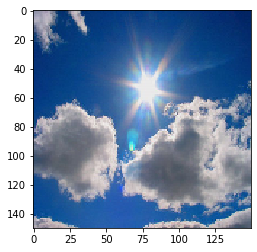

Predicted class probability for image:  [[0.50543684 0.00173727 0.00358997 0.48923594]]
Predicted Class : Cloudy


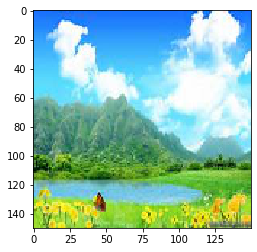

Predicted class probability for image:  [[3.6084230e-06 3.4483733e-10 4.3981565e-09 9.9999642e-01]]
Predicted Class : Sunshine


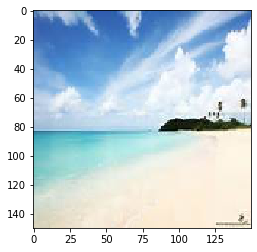

Predicted class probability for image:  [[1.5988756e-03 1.4476609e-06 7.2054040e-06 9.9839240e-01]]
Predicted Class : Sunshine


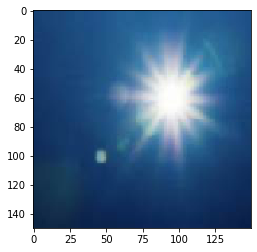

Predicted class probability for image:  [[2.5764275e-02 2.8319802e-04 7.8769729e-02 8.9518273e-01]]
Predicted Class : Sunshine


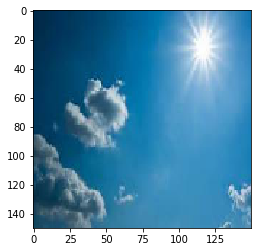

Predicted class probability for image:  [[2.1245892e-03 1.7922035e-05 1.8284546e-03 9.9602914e-01]]
Predicted Class : Sunshine


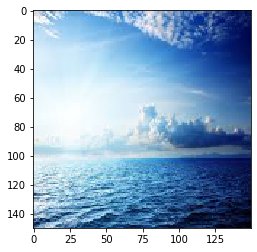

Predicted class probability for image:  [[1.7902175e-03 9.9722647e-06 3.2583244e-05 9.9816716e-01]]
Predicted Class : Sunshine


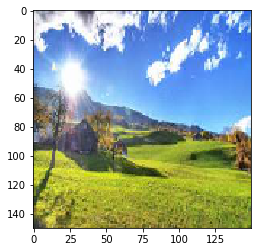

Predicted class probability for image:  [[1.6543339e-04 1.7315877e-07 1.7233580e-06 9.9983275e-01]]
Predicted Class : Sunshine


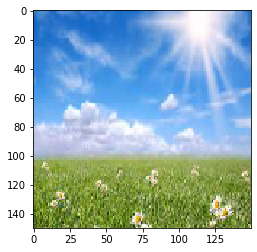

Predicted class probability for image:  [[6.5262958e-02 2.3192544e-04 6.3173450e-04 9.3387336e-01]]
Predicted Class : Sunshine


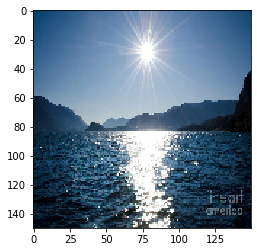

Predicted class probability for image:  [[7.4835867e-04 9.9122317e-06 4.3614674e-04 9.9880564e-01]]
Predicted Class : Sunshine


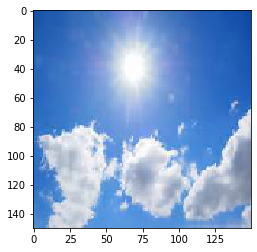

Predicted class probability for image:  [[5.7945289e-02 6.9427726e-05 1.9002191e-04 9.4179523e-01]]
Predicted Class : Sunshine


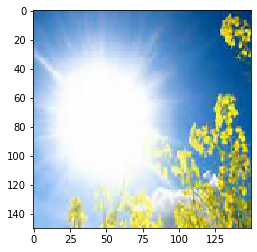

Predicted class probability for image:  [[8.7926805e-04 3.0519222e-06 2.2689488e-05 9.9909496e-01]]
Predicted Class : Sunshine


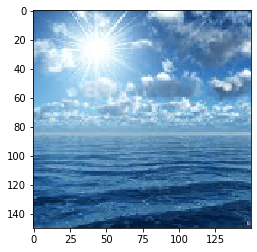

Predicted class probability for image:  [[2.8336709e-02 2.7401089e-03 7.7092653e-04 9.6815223e-01]]
Predicted Class : Sunshine


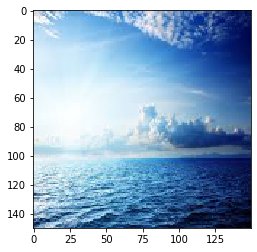

Predicted class probability for image:  [[1.7902175e-03 9.9722647e-06 3.2583244e-05 9.9816716e-01]]
Predicted Class : Sunshine


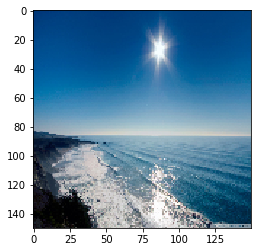

Predicted class probability for image:  [[1.7970292e-03 2.5365553e-05 5.3370645e-04 9.9764389e-01]]
Predicted Class : Sunshine


In [0]:
class_dict={ 0:'Cloudy', 1:'Rain', 2:'Sunrise',3 :'Sunshine'}
sunny1=os.listdir('dataset/test/sunshine')
#print(sunny1)
for img in sunny1:
    img_path='dataset/test/sunshine/'+img
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    plt.imshow(img_tensor/255)
    plt.show()
    img_tensor = np.expand_dims(img_tensor, axis=0)
         
    img_tensor /= 255. 
    ### predict takes image tensor of (batchsize,heighht,width,channels)  
    ### return an array for all images in batch with probability for each class 
    pred = model_final.predict(img_tensor)
    print('Predicted class probability for image: ',pred)
    ###  Class number with highest probablity (Classification result of CNN)  
    classes = np.argmax(pred) 
    print('Predicted Class :',class_dict[classes])
 

#### Repeating the process for all the other Images from Test set : Cloudy , Sunrise and Sunshine

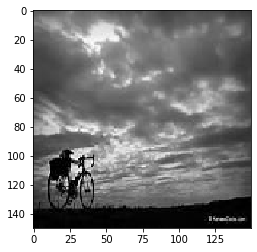

Predicted class probability for imagey:  [[9.9994445e-01 3.1215943e-05 1.8779717e-06 2.2385966e-05]]
Class : Cloudy


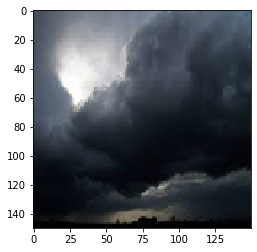

Predicted class probability for imagey:  [[9.9978667e-01 6.1306499e-05 8.8198714e-05 6.3832624e-05]]
Class : Cloudy


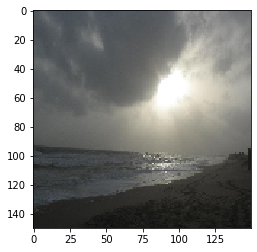

Predicted class probability for imagey:  [[9.9887389e-01 9.6427294e-04 8.3673236e-05 7.8207893e-05]]
Class : Cloudy


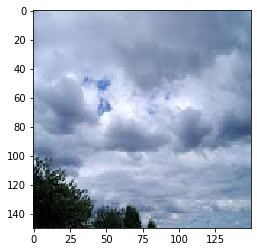

Predicted class probability for imagey:  [[9.2302358e-01 4.1266623e-05 4.6654037e-05 7.6888517e-02]]
Class : Cloudy


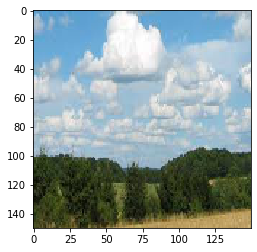

Predicted class probability for imagey:  [[0.1779004  0.00176615 0.00164577 0.8186877 ]]
Class : Sunshine


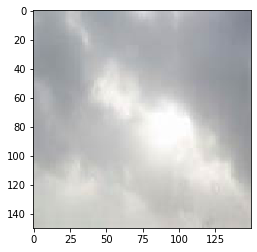

Predicted class probability for imagey:  [[0.89892983 0.05208231 0.01921088 0.02977706]]
Class : Cloudy


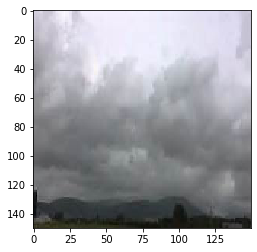

Predicted class probability for imagey:  [[9.9999404e-01 1.9735328e-06 3.8259122e-07 3.5834250e-06]]
Class : Cloudy


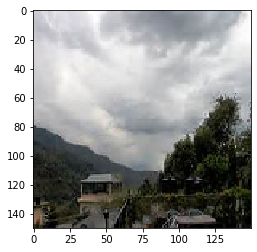

Predicted class probability for imagey:  [[9.9285537e-01 3.0416432e-03 6.8619603e-04 3.4168465e-03]]
Class : Cloudy


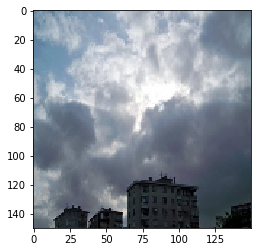

Predicted class probability for imagey:  [[9.9954909e-01 6.8459347e-05 1.3963608e-05 3.6844768e-04]]
Class : Cloudy


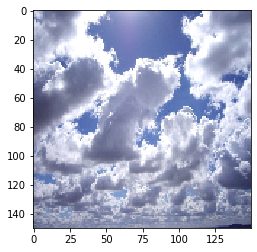

Predicted class probability for imagey:  [[1.8781322e-01 4.1624967e-06 2.6579833e-06 8.1217998e-01]]
Class : Sunshine


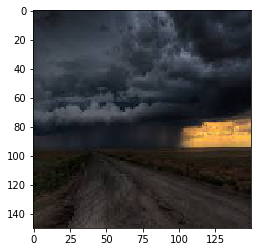

Predicted class probability for imagey:  [[0.4166783  0.00760964 0.56586295 0.00984911]]
Class : Sunrise


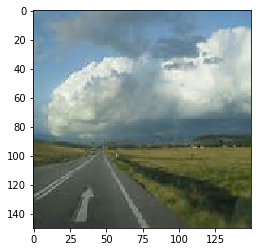

Predicted class probability for imagey:  [[8.7036145e-01 7.1220211e-04 1.0234148e-03 1.2790298e-01]]
Class : Cloudy


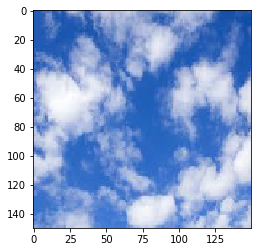

Predicted class probability for imagey:  [[0.564567   0.04742185 0.00397278 0.3840383 ]]
Class : Cloudy


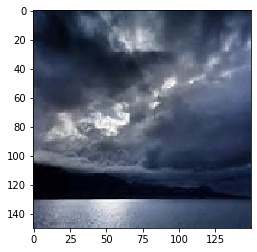

Predicted class probability for imagey:  [[9.9938595e-01 4.7022433e-05 1.6078158e-05 5.5093365e-04]]
Class : Cloudy


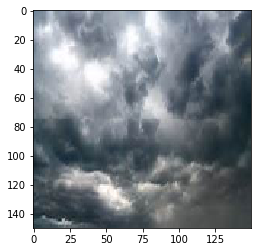

Predicted class probability for imagey:  [[9.9999464e-01 8.5741664e-07 3.3008547e-08 4.5522265e-06]]
Class : Cloudy


In [0]:
cloudy=os.listdir('dataset/test/cloudy')
for img in cloudy:
    img_path='./dataset/test/cloudy/'+img
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    plt.imshow(img_tensor/255)
    plt.show()
    img_tensor = np.expand_dims(img_tensor, axis=0)
         
    img_tensor /= 255. 
    pred = model_final.predict(img_tensor)
    print('Predicted class probability for imagey: ',pred)
    classes = np.argmax(pred) 
    print('Class :',class_dict[classes])

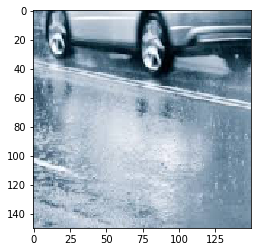

Predicted class probability for image:  [[5.9923327e-06 9.9995553e-01 1.4535554e-09 3.8466143e-05]]
Class : Rain


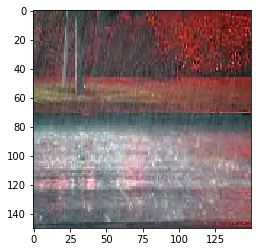

Predicted class probability for image:  [[7.9318010e-09 1.0000000e+00 3.8193956e-14 2.1614850e-08]]
Class : Rain


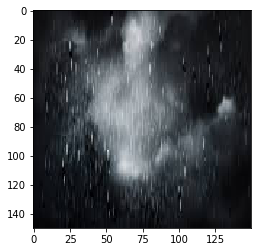

Predicted class probability for image:  [[5.8869017e-07 9.9999499e-01 1.9606280e-10 4.3533050e-06]]
Class : Rain


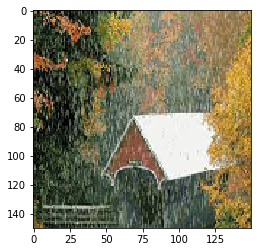

Predicted class probability for image:  [[2.5568155e-04 9.8058164e-01 1.0065424e-04 1.9062033e-02]]
Class : Rain


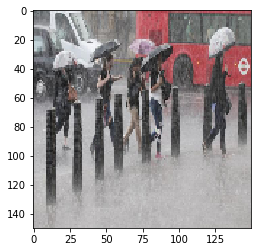

Predicted class probability for image:  [[4.0987526e-08 9.9999833e-01 4.6276754e-12 1.6580291e-06]]
Class : Rain


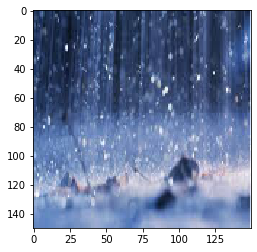

Predicted class probability for image:  [[1.0827116e-06 9.9998295e-01 6.4633687e-10 1.6030272e-05]]
Class : Rain


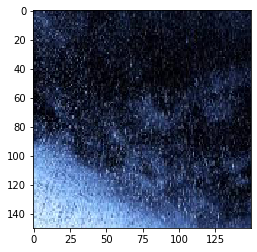

Predicted class probability for image:  [[2.0865527e-06 9.9998462e-01 5.1900573e-09 1.3264057e-05]]
Class : Rain


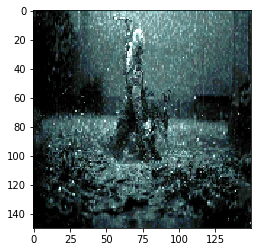

Predicted class probability for image:  [[1.4955859e-04 9.9675602e-01 4.3317787e-06 3.0900079e-03]]
Class : Rain


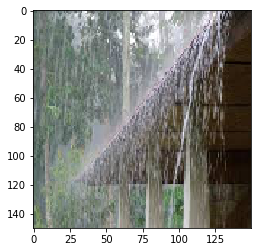

Predicted class probability for image:  [[1.7931910e-09 9.9999976e-01 7.3468419e-14 2.6588452e-07]]
Class : Rain


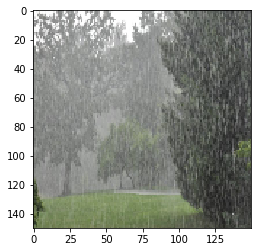

Predicted class probability for image:  [[4.8646863e-12 1.0000000e+00 2.8769168e-18 2.9891253e-10]]
Class : Rain


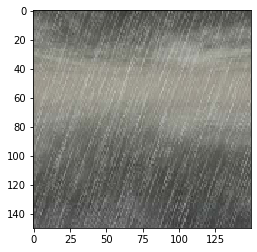

Predicted class probability for image:  [[3.0346700e-13 1.0000000e+00 3.3938313e-20 6.4181655e-12]]
Class : Rain


In [0]:
rain=os.listdir('dataset/test/rain')
for img in rain:
    img_path='./dataset/test/rain/'+img
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    plt.imshow(img_tensor/255)
    plt.show()
    img_tensor = np.expand_dims(img_tensor, axis=0)
         
    img_tensor /= 255. 
    pred = model_final.predict(img_tensor)
    print('Predicted class probability for image: ',pred)
    classes = np.argmax(pred) 
    print('Class :',class_dict[classes])

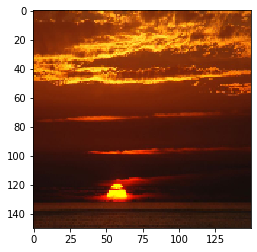

Predicted class probability for image:  [[9.246501e-11 6.120600e-16 1.000000e+00 9.435469e-12]]
Classes : Sunrise


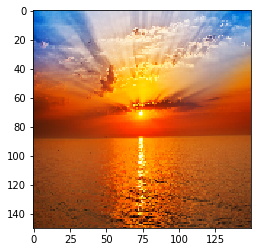

Predicted class probability for image:  [[3.2168398e-12 2.9257368e-17 1.0000000e+00 7.4203685e-11]]
Classes : Sunrise


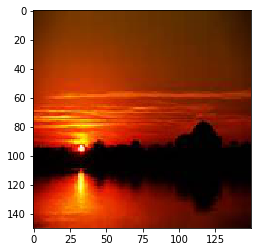

Predicted class probability for image:  [[3.6923517e-10 2.5544568e-15 1.0000000e+00 1.4022929e-10]]
Classes : Sunrise


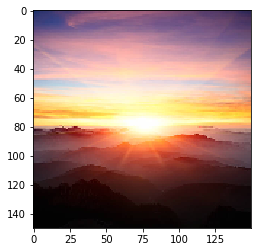

Predicted class probability for image:  [[2.9150275e-08 8.0581825e-13 1.0000000e+00 1.0688582e-08]]
Classes : Sunrise


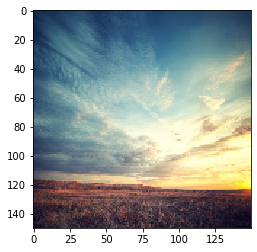

Predicted class probability for image:  [[1.7278442e-03 1.5830493e-04 9.9526536e-01 2.8486017e-03]]
Classes : Sunrise


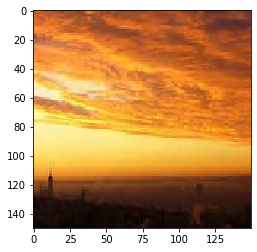

Predicted class probability for image:  [[7.1140067e-17 9.6682102e-25 1.0000000e+00 8.4545434e-16]]
Classes : Sunrise


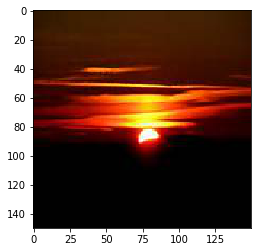

Predicted class probability for image:  [[1.0620954e-07 4.1012293e-12 9.9999988e-01 4.1855808e-09]]
Classes : Sunrise


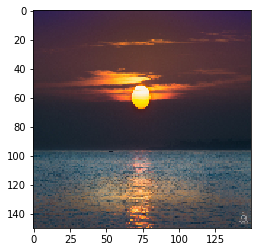

Predicted class probability for image:  [[3.3850293e-04 2.4045883e-06 9.9963331e-01 2.5720170e-05]]
Classes : Sunrise


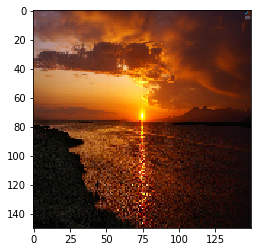

Predicted class probability for image:  [[7.8483424e-08 1.8492081e-11 9.9999988e-01 2.1807699e-08]]
Classes : Sunrise


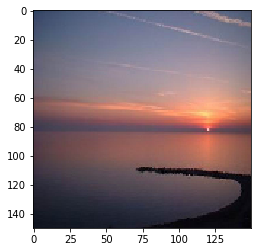

Predicted class probability for image:  [[2.1876405e-04 3.4428361e-08 9.9977130e-01 9.8417495e-06]]
Classes : Sunrise


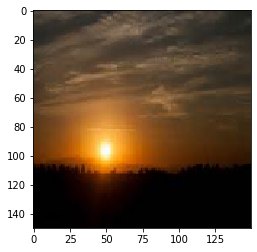

Predicted class probability for image:  [[7.0949143e-04 6.4606695e-07 9.9924564e-01 4.4158227e-05]]
Classes : Sunrise


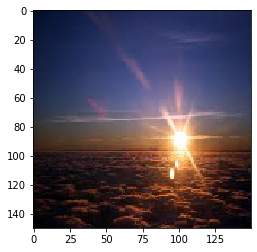

Predicted class probability for image:  [[2.4812252e-03 4.8041507e-05 9.6253026e-01 3.4940451e-02]]
Classes : Sunrise


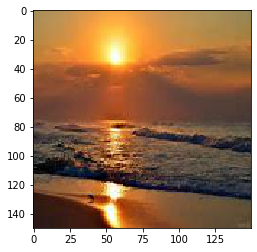

Predicted class probability for image:  [[3.4705891e-07 1.7877493e-10 9.9999940e-01 2.6640271e-07]]
Classes : Sunrise


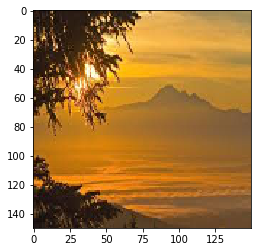

Predicted class probability for image:  [[8.4751556e-10 8.3629108e-14 1.0000000e+00 3.8613198e-08]]
Classes : Sunrise


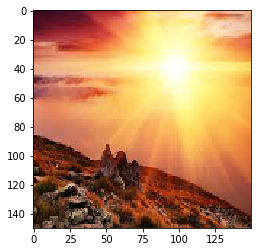

Predicted class probability for image:  [[4.8773871e-12 2.9988457e-17 1.0000000e+00 5.1719098e-11]]
Classes : Sunrise


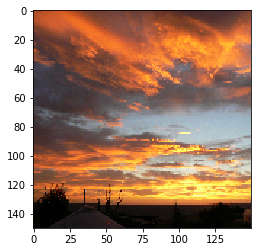

Predicted class probability for image:  [[1.0187425e-13 2.2563075e-20 1.0000000e+00 1.4345500e-15]]
Classes : Sunrise


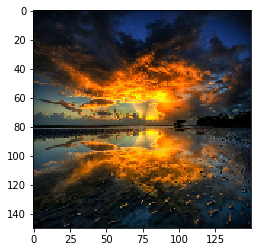

Predicted class probability for image:  [[7.7698488e-08 3.1032565e-11 9.9999988e-01 3.9923574e-08]]
Classes : Sunrise


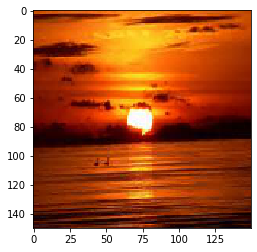

Predicted class probability for image:  [[4.44704085e-19 6.42232636e-28 1.00000000e+00 1.02329835e-19]]
Classes : Sunrise


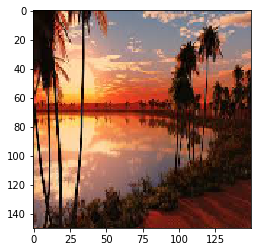

Predicted class probability for image:  [[4.9992508e-07 1.0837802e-08 9.9999774e-01 1.7875487e-06]]
Classes : Sunrise


In [0]:
sun_rise=os.listdir('dataset/test/sunrise')
for img in sun_rise:
    img_path='./dataset/test/sunrise/'+img
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    plt.imshow(img_tensor/255)
    plt.show()
    img_tensor = np.expand_dims(img_tensor, axis=0)
         
    img_tensor /= 255. 
    pred = model_final.predict(img_tensor)
    print('Predicted class probability for image: ',pred)
    classes = np.argmax(pred) 
    print('Classes :',class_dict[classes])

## Intepreting  Machine Learning Model using LIME

With the increase in trend of using machine learning model in critical applications it is necessary that the predections from the model are trustable.

When Training the model we divide the data into train and test sets. After Training we evaluate the performance of the Model on the Test set to get an estimate of the performance. But it is not necessary that a good performance on Test Data will give similar performance in real world application.

There are two important questions to ask when using A Machine Learining Model.
### WHAT and WHY ?

What is the predection of the Model ? and Why the Model made a particular predection ?

**Local Interpretable Model-agnostic Explanations(LIME)** is a technique that explains how the input features of a machine learning model affect its predictions. For instance, for image classification tasks, LIME finds the region of an image (set of super-pixels) with the strongest association with a prediction label. This post is a step by step guide with Python code on how LIME for image classification internally works.

Paper on Lime : [Why Should I Trust you": EXplaning predictions of any classifer](https://arxiv.org/abs/1602.04938)

Github Repository for Lime :[Lime](https://github.com/marcotcr/lime)





In [0]:
!pip install lime
import lime 
from lime import lime_image
from skimage.segmentation import mark_boundaries

     |████████████████████████████████| 276kB 2.0MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=d97c0c3ea55a1aa2aa278f26cdd8f265c182f85e16d7ef2f0952d8ce46b73076
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12073 sha256=e0a72b6b97e01627248d20bf05e3332f96e16df9ae962ae30c5f03688a0b5212
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


#### Selecting Image for which you want Explanation

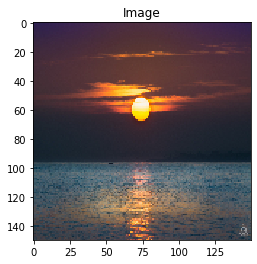

In [0]:
img_path='./dataset/test/sunrise/'+sun_rise[7]  ### repalce path with the path for image u want to be expalined
img = image.load_img(img_path, target_size=(150, 150))
img = image.img_to_array(img)/255

plt.imshow(img)
plt.title('Image')
plt.show()

img = np.expand_dims(img, axis=0)

#### Creating an instance of LIME Image Explainer
Detailed documentation for Lime Package :
[Lime Doc](https://lime-ml.readthedocs.io)

Gives detailed expalnation of all the classes and methods that can be used of explanaing models

***Image Explainer***

Explains predictions on Image (i.e. matrix) data. For numerical features, perturb them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, perturb by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained.


In [0]:
explainer = lime_image.LimeImageExplainer()

#### Generating explanation for image by passing image and keras CNN ***Model to instance expaliner***
Takes the Image, predection model and number of features we want to be explained as top_tabels

We select top_labels as four since we have four clases

Returns an explanation object

 


In [0]:
%%time 
explanation = explainer.explain_instance(img, model_final.predict, top_labels=4
                                         , hide_color=0, num_samples=1000)

CPU times: user 2.11 s, sys: 291 ms, total: 2.4 s
Wall time: 2.43 s


#### Labels in expaliner

top_labels gives the CNN models predection in order with the first (0) predection being the Class which has highest probablity.



In [0]:
print('Class Order')
labels=[print(no+1,class_dict[label]) for no,label in enumerate(explanation.top_labels)]

print('For current image instance CNN model has classified Image as: ',class_dict[explanation.top_labels[0]])

Class Order
1 Sunrise
2 Cloudy
3 Sunshine
4 Rain
For current image instance CNN model has classified Image as:  Sunrise


#### Explaning Instance
We plot the image with the super pixels (region of image) that contributed to a particula class

***get_image_and_mask*** takes the labels(classes) to be expalined and returns Image and the mask for super pixels

***positive_only*** if set True only returns the super pixel that contributed to selected class 

***hide_rest*** is set True hides the image other than background.
This helps us to easily visualize the super_pixels that led to a particular classification.



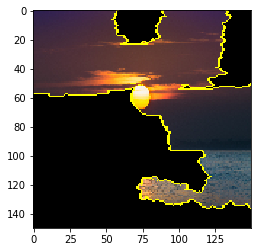

In [0]:
### Expalaning the predection for top class (Class with highest probablity)
### change the index of top_labels to see the explanation for other classes 
### note : Explanation for other classes will  be less informative as the Model has very low probablity (confidence) on those classes
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=True)
plt.imshow(mark_boundaries(temp,mask))


For the above instance we can see the super pixels that contributed to the class Sunrise.
We can clearly see that the orange colour in the sky played a decisive role in this classification. Which is correct hence we are now assured Model gave importance to correct feature for this classifiation


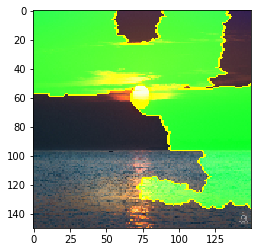

In [0]:
## setting positive_only to False so we get superpixels having positive and negative impact on classification
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp,mask))



The green mask shows the superpixels having positive impact on the classification to a particular class. 
Red  maks show the super pixels  which have negative impact on classfication to a particular class.
Here for this instance we don't have any superpixels which had a negative impact on classification.

## Conclusion

We Trained A CNN classifer from scratch  to classify Weather Images with validation accuracy>95%

We used Lime to expalantion the classification Model results which highlight the superpixels that contributed to the classification of Image.

The same process can be repeated on any other dataset for training some other classifer or explaning a new Weather using using the same Model.

